In [1]:
%run ../robustness_analysis.ipynb

## Define parametric environment

In [2]:
# Create a mutated environment
from gym.envs.classic_control import CartPoleEnv
from types import SimpleNamespace

class MutatedCartPoleEnv(CartPoleEnv):
    def __init__(self, masscart = 1.0, masspole = 0.1, length = 0.5, force_mag = 10.0):
        super().__init__()
        
        self.spec = SimpleNamespace()
        self.spec.id = f"MutatedCartPole-{masscart:.3f}-{masspole:.3f}-{length:.3f}-{force_mag:.3f}"
        
        self.gravity = 9.8
        self.masscart = masscart
        self.masspole = masspole
        self.total_mass = self.masspole + self.masscart
        self.length = length  # actually half the pole's length
        self.polemass_length = self.masspole * self.length
        self.force_mag = force_mag
        self.tau = 0.02  # seconds between state updates
    
    def reset_to(self, state, seed=None):
        self.seed(seed)
        self.state = state
        self.steps_beyond_done = None
        return np.array(self.state, dtype=np.float32)

## Define deviation domain

In [3]:
masscart = [0.1, 2.0]
force_mag = [1.0, 20.0]

# define the range of the deviation parameters
dev_bounds = np.asarray([masscart, force_mag])

# define the range of the initial states
x0_bounds = np.repeat([[-0.05, 0.05]], 4, axis=0)

# define the deviation parameter value for the original environment (no deviation)
delta_0 = np.asarray([
    1.0, # default masscart (not normalized)
    10.0 # default force_mag
])

## Define system and controller

In [4]:
def env_builder(delta):
    return MutatedCartPoleEnv(masscart=delta[0], force_mag=delta[1]), x0_bounds

In [5]:
# credits to: https://gist.github.com/HenryJia/23db12d61546054aa43f8dc587d9dc2c
class PID:
    def __init__(self):
        self.desired_state = np.array([0, 0, 0, 0])
        self.desired_mask = np.array([0, 0, 1, 0])
        self.P, self.I, self.D = 0.1, 0.01, 0.5
        
        self.reset()
    
    def reset(self):
        self.integral = 0
        self.derivative = 0
        self.prev_error = 0
    
    def sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-x))
    
    def next_action(self, obs):
        error = obs - self.desired_state

        self.integral += error
        self.derivative = error - self.prev_error
        self.prev_error = error

        pid = np.dot(self.P * error + self.I * self.integral + self.D * self.derivative, self.desired_mask)
        action = self.sigmoid(pid)
        return np.round(action).astype(np.int32)

In [6]:
model = PID()

agent = {
    # define the action generation function of the given agent
    'next_action': lambda obs: model.next_action(obs),

    # some agents (like PID) needs to be reset for each run
    'model_reset': lambda : model.reset()
}

## Define STL property

In [7]:
obs_space = MutatedCartPoleEnv().observation_space
pos_range = np.asarray([obs_space.low[0], obs_space.high[0]])
angle_range = np.asarray([obs_space.low[2], obs_space.high[2]])

def stl_prop():
    pos = stl.Predicate('pos')
    angle = stl.Predicate('angle')

    pos_threshold = normalize(2.4, pos_range)
    angle_threshold = normalize(12 * 2 * np.pi / 360, angle_range)

    return stl.Always( (pos < pos_threshold) & (angle < angle_threshold) )


def signal_builder(record, time_index):
    return {
        "pos": stl.Signal(
            normalize(np.abs(record[:, 0]), pos_range),
            time_index
        ),
        "angle": stl.Signal(
            normalize(np.abs(record[:, 2]), angle_range),
            time_index
        )
    }

def episode_eval(obs_record, reward_record):
    return compute_stl_rob(stl_prop(), signal_builder, obs_record)

## Define distance function

In [8]:
# l-2 norm distance
def dist(delta, delta_0):
    delta = normalize(delta, dev_bounds)
    delta_0 = normalize(delta_0, dev_bounds)
    return np.sqrt(np.sum((delta - delta_0) ** 2))

In [9]:
if not os.path.exists('gifs'):
    os.mkdir('gifs')

## Create the baseline Robustness Analyzer

In [10]:
analysis = RobustnessAnalysis(env_builder, agent, episode_eval, delta_0, dev_bounds, dist)
analysis.options['deviation_restarts'] = 2
analysis.options['deviation_sigma'] = 0.2
analysis.options['deviation_evals'] = 100
analysis.options['falsification_sigma'] = 0.4
analysis.options['falsification_timeout'] = 1
analysis.options['falsification_restarts'] = 0
analysis.options

{'epsilon': 0.01,
 'deviation_restarts': 2,
 'deviation_sigma': 0.2,
 'deviation_timeout': inf,
 'deviation_evals': 100,
 'falsification_sigma': 0.4,
 'falsification_timeout': 1,
 'falsification_restarts': 0,
 'falsification_episodes': 100,
 'episodes_of_each_x0': 1,
 'steps_of_each_x0': 200}

## Min deviation and Plot the convergence

In [11]:
def min_dev_and_convergence(analysis, out_dir='data'):
    start = datetime.now()
    result = analysis.min_unsafe_deviation()
    print('===================== Summary ====================>')
    print('Time to find min unsafe deviation:', datetime.now() - start)
    print('Min x:', result.delta, 'Min distance:', result.delta_dist)
    
    for i in range(len(result.Dists)):
        analysis.heatmap(masscart, force_mag, 25, 25, x_name="Masses", y_name="Forces", z_name="STL Satisfaction",
                         out_dir=out_dir, boundary=result.Dists[i])
        plt.scatter(result.Xss[i][:, 0] * 24, result.Xss[i][:, 1] * 24, c=np.arange(len(result.Xss[i])), cmap='Greys')
        if result.Means is not None and result.Sigmas is not None:
            plt.title(f'Mean: {result.Means[i]}, Sigma: {result.Sigmas[i]}')
        plt.show()

### BasicCMA

In [ ]:
min_dev_and_convergence(analysis)

### Random

In [ ]:
min_dev_and_convergence(RandomMinDev(analysis))

### SmartCMA

In [ ]:
min_dev_and_convergence(SmartCMA(analysis))

## PyGMO

In [ ]:
min_dev_and_convergence(NSGA2(analysis, gen=15, popsize=20))

In [ ]:
min_dev_and_convergence(GACO(analysis, gen=15, popsize=20))

## Compare the number of evaluations

In [12]:
def run_data(analysis, name, n=10, evals=50, out_dir='data'):
    dists_name = f"{out_dir}/{name}-dists-{n}-{evals}.csv"
    times_name = f"{out_dir}/{name}-times-{n}-{evals}.csv"
    if os.path.exists(dists_name) and os.path.exists(times_name):
        dists = np.loadtxt(dists_name, delimiter=',')
        times = np.loadtxt(times_name, delimiter=',')
    else:
        tmp = analysis.options['deviation_evals']
        analysis.options['deviation_evals'] = evals
        dists, times = [], []
        for _ in range(n):
            start = datetime.now()
            result = analysis.min_unsafe_deviation()
            dists.append(result.delta_dist)
            times.append((datetime.now() - start).total_seconds())

        dists, times = np.array(dists), np.array(times)
        np.savetxt(dists_name, dists, delimiter=',')
        np.savetxt(times_name, times, delimiter=',')
        
        analysis.options['deviation_evals'] = tmp
    return dists, times

In [13]:
def run_data2(analysis, name, n=10, popsize=20, gen=15, out_dir='data'):
    dists_name = f"{out_dir}/{name}-dists-{n}-{popsize}-{gen}.csv"
    times_name = f"{out_dir}/{name}-times-{n}-{popsize}-{gen}.csv"
    if os.path.exists(dists_name) and os.path.exists(times_name):
        dists = np.loadtxt(dists_name, delimiter=',')
        times = np.loadtxt(times_name, delimiter=',')
    else:
        dists, times = [], []
        for _ in range(n):
            start = datetime.now()
            result = analysis.min_unsafe_deviation()
            dists.append(result.delta_dist)
            times.append((datetime.now() - start).total_seconds())

        dists, times = np.array(dists), np.array(times)
        np.savetxt(dists_name, dists, delimiter=',')
        np.savetxt(times_name, times, delimiter=',')
    return dists, times

In [14]:
def test_evals(analysis, name, out_dir):
    evals = np.arange(50, 151, 25)
    data = []
    data_times = []
    for e in evals:
        dists, times = run_data(analysis, name, evals=e, out_dir=out_dir)
        data.append(dists)
        data_times.append(times)
    # plt.boxplot(data, labels=evals)
    # plt.show()
    return data, data_times

### Basic CMA

In [15]:
data1, times1 = test_evals(analysis, 'BasicCMA', 'data')

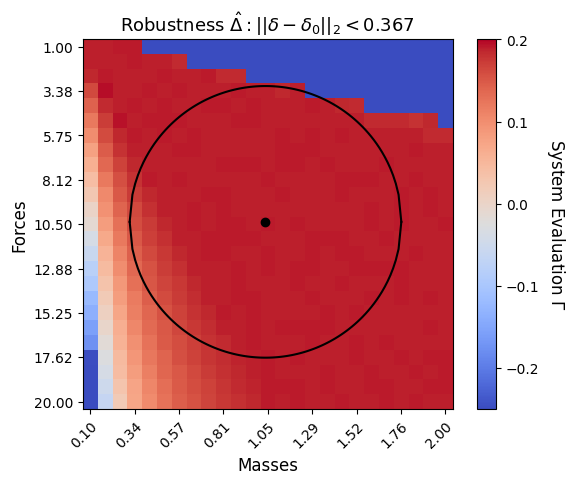

In [21]:
plt.rc('axes', labelsize=12, titlesize=13)
_ = analysis.heatmap(masscart, force_mag, 25, 25, x_name="Masses", y_name="Forces", z_name="System Evaluation $\Gamma$",
                 out_dir='data', boundary=np.min(data1), vmax=0.2)
plt.title('Robustness $\hat{\Delta}: ||\delta - \delta_0||_2 < %.3f$' % np.min(data1))
plt.savefig('gifs/robustness-landscape-boundary-heatmap.png', bbox_inches='tight')

### Random sample

In [22]:
data2, times2 = test_evals(RandomMinDev(analysis), 'Random', 'data')

### SmartCMA

In [17]:
data3, times3 = test_evals(SmartCMA(analysis), 'SmartCMA2', 'data')

## NSGA2

In [ ]:
data4 = run_data2(NSGA2(analysis, gen=15, popsize=20), 'NSGA', popsize=20, gen=15, out_dir='data')

## GACO

In [ ]:
data5 = run_data2(GACO(analysis, gen=15, popsize=20), 'GACO', popsize=20, gen=15, out_dir='data')

In [ ]:
plt.boxplot([data4[0], data5[0],
             np.loadtxt('data/BasicCMA-dists-10-100.csv', delimiter=','),
             np.loadtxt('data/SmartCMA-dists-10-100.csv', delimiter=','),
             np.loadtxt('data/Random-dists-10-100.csv', delimiter=',')],
            labels=['NSGA2', 'Ant', 'BasicCMA', 'SmartCMA', 'Random'])

In [32]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

def boxplot(datas, colors, labels, legends):
    num_group = len(datas)
    num_each_group = len(datas[0])
    total = num_group * num_each_group
    for i in range(num_group):
        bp = plt.boxplot(datas[i], positions=np.arange(i+1, total+1, num_group)+np.arange(num_each_group), showfliers=False)
        set_box_color(bp, colors[i])
    
    plt.xticks(np.arange(1+(num_group-1)/2, total, num_group)+np.arange(num_each_group), labels=labels)

    for i in range(num_group):
        plt.plot([], c=colors[i], label=legends[i])
    plt.legend()

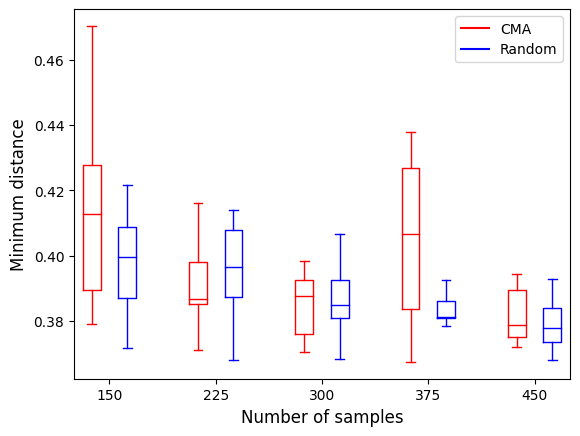

In [33]:
plt.xlabel('Number of samples')
plt.ylabel('Minimum distance')
boxplot([data1, data2], ['red', 'blue'], np.arange(50, 151, 25)*(analysis.options['deviation_restarts']+1),
        ['CMA', 'Random'])
plt.savefig('gifs/sample-boxplot.png', bbox_inches='tight')

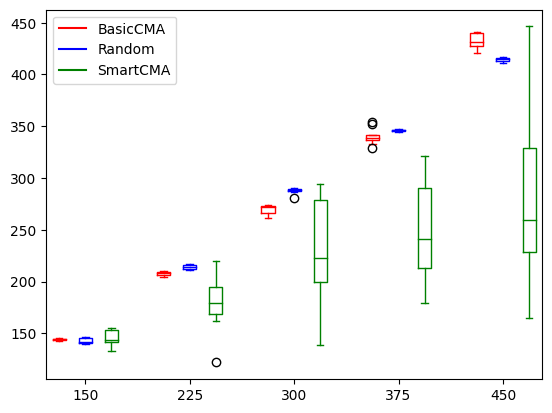

In [20]:
boxplot([times1, times2, times3], ['red', 'blue', 'green'], np.arange(50, 151, 25)*(analysis.options['deviation_restarts']+1),
        ['BasicCMA', 'Random', 'SmartCMA'])

## Use any deviation and boundary

In [ ]:
class AnyDevWithBoundary(RADecorator):
    def min_unsafe_deviation(self, boundary=None):
        num_tries = self.options['deviation_restarts']
        tmp_evals = self.options['deviation_evals']
        
        total_evals = tmp_evals * (num_tries + 1)
        self.options['deviation_restarts'] = 0
        
        evals = 0
        delta = None
        while evals < total_evals:
            self.options['deviation_evals'] = min(total_evals - evals, tmp_evals)
            result = self.any_unsafe_deviation(boundary)
            if result.delta_dist != np.inf and (boundary is None or result.delta_dist < boundary):
                delta, boundary = result.delta, result.delta_dist
            evals += result.evals
        
        self.options['deviation_restarts'] = num_tries
        self.options['deviation_evals'] = tmp_evals
        return RAResult(delta, boundary)

In [ ]:
ra = AnyDevWithBoundary(analysis).min_unsafe_deviation()
ra.delta, ra.delta_dist

## Add number of violations to evaluate each episode

In [ ]:
def episode_eval2(obs_record, reward_record):
    pos = normalize(np.abs(obs_record[:, 0]), pos_range)
    angle = normalize(np.abs(obs_record[:, 2]), angle_range)
    
    pos_threshold = normalize(2.4, pos_range)
    angle_threshold = normalize(12 * 2 * np.pi / 360, angle_range)
    
    rob = compute_stl_rob(stl_prop(), signal_builder, obs_record)
    violations = -np.sum((pos >= pos_threshold) | (angle >= angle_threshold))
    return rob + violations / 200

In [ ]:
analysis2 = RobustnessAnalysis(env_builder, agent, episode_eval2, delta_0, dev_bounds, dist)
analysis2.options = analysis.options

### Basic CMA

In [ ]:
data1 = test_evals(analysis2, 'BasicCMA', 'data_violation')

### Random sample

In [ ]:
data2 = test_evals(RandomMinDev(analysis2), 'Random', 'data_violation')

### SmartCMA

In [ ]:
data3 = test_evals(SmartCMA(analysis2), 'SmartCMA', 'data_violation')

In [ ]:
boxplot([data1, data2], ['red', 'blue', 'green'], np.arange(50, 151, 25)*(analysis2.options['deviation_restarts']+1),
        ['BasicCMA', 'Random', 'SmartCMA'])

## Use Cumulative STL Satisfication metric

In [ ]:
def episode_eval3(obs_record, reward_record):
    pos = normalize(np.abs(obs_record[:, 0]), pos_range)
    angle = normalize(np.abs(obs_record[:, 2]), angle_range)
    
    pos_threshold = normalize(2.4, pos_range)
    angle_threshold = normalize(12 * 2 * np.pi / 360, angle_range)
    
    rob_at_each = np.min([pos_threshold - pos, angle_threshold - angle], axis=0)
    
    positive, negative = np.sum(rob_at_each[rob_at_each > 0]), np.sum(rob_at_each[rob_at_each < 0])
    return positive if negative == 0 else negative

In [ ]:
analysis3 = RobustnessAnalysis(env_builder, agent, episode_eval3, delta_0, dev_bounds, dist)
analysis3.options = analysis.options; analysis3.options

In [ ]:
min_dev_and_convergence(analysis3, 'data_cumulative2')

In [ ]:
test_evals(analysis3, 'BasicCMA', 'data_cumulative')

In [ ]:
test_evals(RandomMinDev(analysis3), 'Random', 'data_cumulative')